In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-8549730-37.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-1237848-61.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-5753467-7.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-364469-83.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-1117376-1.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-7345121-21.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-8086850-35.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/DRUSEN-2444883-33.jpeg
/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val/DRUSEN/

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory


2025-07-27 14:01:26.039870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753624886.235696      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753624886.292675      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

In [2]:
training_set = image_dataset_from_directory(
    "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/train",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # Mobile net in train img size
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 76515 files belonging to 4 classes.


I0000 00:00:1753624949.787767      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [3]:
validation_set = image_dataset_from_directory(
    "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # Mobile net in train img size
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 21861 files belonging to 4 classes.


In [4]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [5]:
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [6]:
INPUT_SHAPE = (224,224,3)

In [7]:
mobilenet = tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    include_top=True,
    weights="imagenet",
    classes=1000,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True
)

22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model = tf.keras.models.Sequential()

In [9]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [10]:
model.add(mobilenet)

In [11]:
model.add(tf.keras.layers.Dense(units=4 , activation='softmax'))  # units=4 -->  we have to predict 4 class 

In [12]:
metrics_list = ['accuracy' , tf.keras.metrics.F1Score() ]

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) , loss='categorical_crossentropy' , metrics=metrics_list)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 1000)           │     5,507,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,511,436 (21.02 MB)

 Trainable params: 5,487,036 (20.93 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [15]:
train_history = model.fit(x=training_set ,validation_data=validation_set ,epochs=15 )

Epoch 1/15


I0000 00:00:1753625041.740363     100 service.cc:148] XLA service 0x7b8ab8003140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753625041.741090     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753625045.547792     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753625052.074967     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753625052.259106     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753625052.688835     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753625052.8859

   1/2392 ━━━━━━━━━━━━━━━━━━━━ 42:53:27 65s/step - accuracy: 0.0625 - f1_score: 0.0478 - loss: 1.3868

I0000 00:00:1753625066.953198     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2391/2392 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8420 - f1_score: 0.6369 - loss: 1.2252

E0000 00:00:1753625243.337381     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753625243.533164     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2392/2392 ━━━━━━━━━━━━━━━━━━━━ 304s 100ms/step - accuracy: 0.8420 - f1_score: 0.6369 - loss: 1.2251 - val_accuracy: 0.8943 - val_f1_score: 0.6891 - val_loss: 0.9577
Epoch 2/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 196s 82ms/step - accuracy: 0.9042 - f1_score: 0.7355 - loss: 0.8858 - val_accuracy: 0.9524 - val_f1_score: 0.9170 - val_loss: 0.7088
Epoch 3/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 194s 81ms/step - accuracy: 0.9520 - f1_score: 0.9156 - loss: 0.6644 - val_accuracy: 0.9557 - val_f1_score: 0.9244 - val_loss: 0.5451
Epoch 4/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 195s 81ms/step - accuracy: 0.9564 - f1_score: 0.9246 - loss: 0.5113 - val_accuracy: 0.9593 - val_f1_score: 0.9316 - val_loss: 0.4226
Epoch 5/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 196s 82ms/step - accuracy: 0.9624 - f1_score: 0.9349 - loss: 0.3973 - val_accuracy: 0.9654 - val_f1_score: 0.9408 - val_loss: 0.3324
Epoch 6/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 196s 82ms/step - accuracy: 0.9668 - f1_score: 0.9421 - loss: 0.3112 - val_accuracy: 0.9697 - 

In [16]:
model.save("eye_disease_predication.h5")

In [17]:
from IPython.display import FileLink
FileLink('eye_disease_predication.h5')


/kaggle/working/eye_disease_predication.h5

In [18]:
import pickle 
with open("Training_history.pkl" , 'wb' ) as f :
    pickle.dump(train_history.history , f)

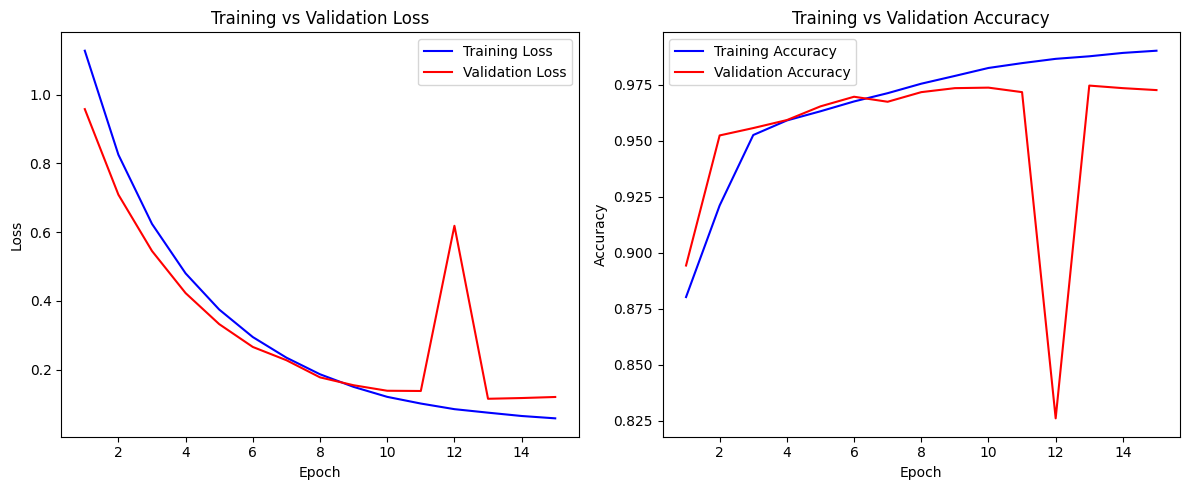

In [19]:

# Extract data from the training history
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_acc = train_history.history.get('accuracy')  # sometimes it's 'acc' depending on version
val_acc = train_history.history.get('val_accuracy')  # or 'val_acc'

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_set = image_dataset_from_directory(
    "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/test",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224), # Mobile net in train img size
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 10933 files belonging to 4 classes.


In [26]:
test_loss , test_acc , f1_score = model.evaluate(test_set)

342/342 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9680 - f1_score: 0.6342 - loss: 0.1312


In [27]:
# Computing True Label from test set 
true_categories = tf.concat([y for x,y in test_set ] , axis = 0)
Y_true = tf.argmax(true_categories , axis =1 )

In [28]:
true_categories

<tf.Tensor: shape=(10933, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [29]:
# Computing Predicted labels using test set 

predicted_categories = model.predict(test_set)
predicted_categories

342/342 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step


array([[0.98484844, 0.00440712, 0.00617173, 0.0045727 ],
       [0.98484844, 0.00440712, 0.00617173, 0.0045727 ],
       [0.98484844, 0.00440712, 0.00617173, 0.0045727 ],
       ...,
       [0.00279595, 0.00400898, 0.00513051, 0.9880646 ],
       [0.00279595, 0.00400898, 0.00513051, 0.9880646 ],
       [0.00279595, 0.00400898, 0.00513051, 0.9880646 ]], dtype=float32)

In [30]:
Y_pred = tf.argmax(predicted_categories , axis =1 )
Y_pred

<tf.Tensor: shape=(10933,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

# Classification Report 

In [31]:
from sklearn.metrics import classification_report 

print(classification_report(Y_true , Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3746
           1       0.96      0.94      0.95      1161
           2       0.90      0.85      0.88       887
           3       0.98      0.99      0.99      5139

    accuracy                           0.97     10933
   macro avg       0.95      0.94      0.95     10933
weighted avg       0.97      0.97      0.97     10933



# Confusion Matrix 

In [32]:
from sklearn.metrics import confusion_matrix 

print(confusion_matrix(Y_true , Y_pred))

[[3643   24   71    8]
 [  13 1095    1   52]
 [  60    8  758   61]
 [   3   18   13 5105]]
